In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

In [2]:
from scipy.stats import kendalltau, pearsonr, spearmanr
def pearsonr_pval(x,y):
    return pearsonr(x,y)[1]
def spearmanr_pval(x,y):
    return spearmanr(x,y)[1]
def sig_pv(x):
    if x <= 0.05:
        return 1
    return 0

In [6]:
oral_tax = pd.read_csv('../data/metagenome/motus_profile.csv')
spnames = [ x.split('[ref')[0].split('[meta')[0].split('[ext')[0].\
           replace('[','').replace(']','').strip() for x in list(oral_tax['Species'])]
oral_tax['Species'] = spnames; oral_tax = oral_tax.rename(columns={'Species':'Sample'})
oral_tax = oral_tax.set_index(['Sample'])
oral_tax = oral_tax.T; oral_quant = oral_tax.groupby(oral_tax.columns, axis=1).sum();
oral_quant = oral_quant.drop(['unassigned'],axis=1)
oral_quant.head()

Sample,Abiotrophia defectiva,Acidaminococcus species incertae sedis,Acidovorax wautersii,Acinetobacter baumannii,Actinobacteria sp.,Actinobaculum sp. oral taxon 183,Actinomyces bouchesdurhonensis,Actinomyces dentalis,Actinomyces gerencseriae,Actinomyces graevenitzii,...,Veillonella atypica,Veillonella denticariosi,Veillonella dispar,Veillonella parvula,Veillonella rogosae,Veillonella sp.,Veillonella species incertae sedis,Veillonella tobetsuensis,Weissella confusa,Weissella paramesenteroides
A10,0.000198,0.0,0.0,0.000000,0.003645,0.000081,0.000000,0.000277,0.000086,0.005495,...,0.001063,0.0,0.002468,0.001105,0.041786,0.001101,0.003468,0.004988,0.0,0.0
A11,0.000440,0.0,0.0,0.000000,0.008368,0.000030,0.016645,0.000115,0.000046,0.016826,...,0.037476,0.0,0.015411,0.003669,0.000787,0.000278,0.039186,0.000157,0.0,0.0
A1,0.010644,0.0,0.0,0.000000,0.003527,0.000910,0.000000,0.000773,0.000822,0.001720,...,0.000949,0.0,0.001753,0.003181,0.011843,0.013361,0.006406,0.002494,0.0,0.0
A20,0.000000,0.0,0.0,0.000672,0.008431,0.001276,0.000000,0.001029,0.001319,0.004478,...,0.003533,0.0,0.004752,0.022527,0.007487,0.002804,0.016425,0.000000,0.0,0.0
A28,0.003256,0.0,0.0,0.000000,0.001518,0.000587,0.000000,0.000649,0.000553,0.000000,...,0.001448,0.0,0.000752,0.003571,0.018238,0.001710,0.003183,0.001323,0.0,0.0


In [10]:
oral_avg = pd.DataFrame( oral_quant.mean(axis=0), columns=['Average']).sort_values(['Average'],ascending=False)
top50_avg = oral_avg.iloc[:50]; rest_avg = oral_avg.iloc[50:];

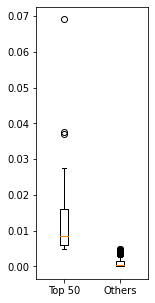

In [26]:
fig, ax = plt.subplots(1,1,figsize=(2,5))
ax.boxplot([top50_avg.Average,rest_avg.Average ], labels=['Top 50','Others']);

In [35]:
Top50_sps = list(top50_avg.index)
Top50sp_quant = oral_quant[Top50_sps]

# Species-species

In [47]:
sps_corr = Top50sp_quant.corr(method='spearman')
sps_sig = Top50sp_quant.corr( method= spearmanr_pval )
sig_sps_corr = sps_corr.copy()
for x in Top50_sps:
    for y in Top50_sps:
        if sps_sig[x][y] > 0.001:
            sig_sps_corr[x][y] = 0
sig_sps_corr = sig_sps_corr[(sig_sps_corr != 0).any(axis=1)]
sig_sps_corr = sig_sps_corr.loc[:, (sig_sps_corr != 0).any(axis=0)]

<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

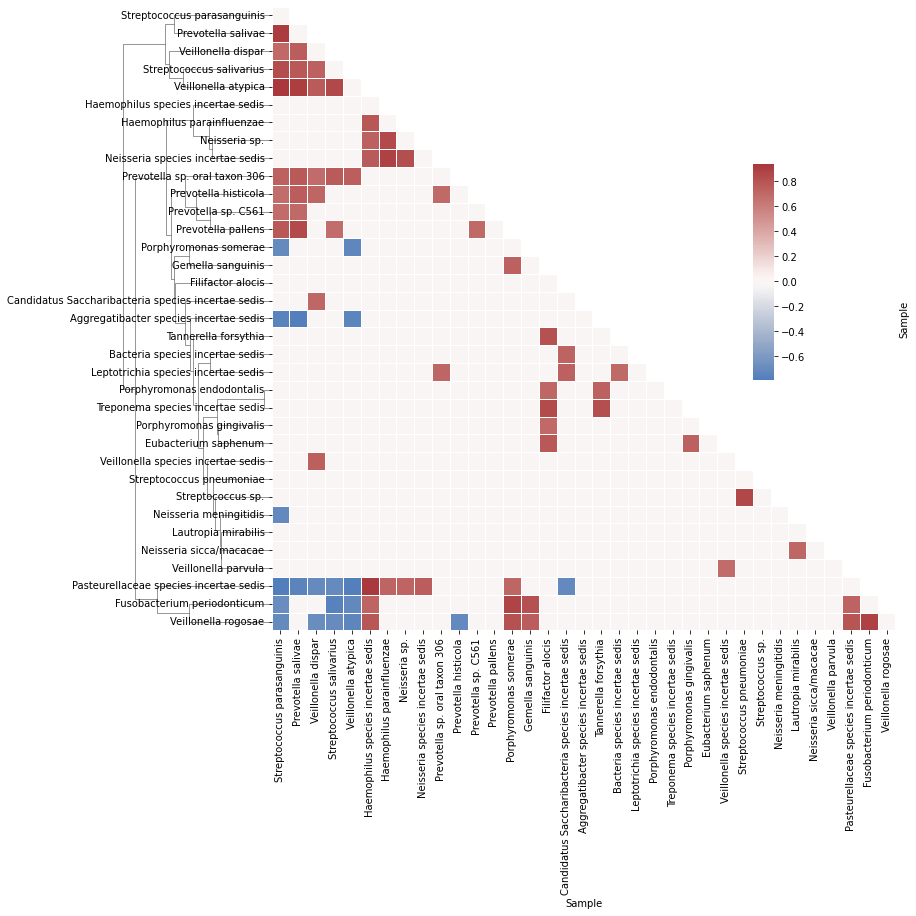

In [76]:
plt.figure()
mask = np.zeros_like(sig_sps_corr)
mask[np.triu_indices_from(mask)] = True
g = sns.clustermap(data=sig_sps_corr,mask = mask, cmap='vlag')
mask = mask[np.argsort(g.dendrogram_row.reordered_ind),:]
mask = mask[:,np.argsort(g.dendrogram_col.reordered_ind)]
mask[np.diag_indices_from(mask)] = False
plt.clf()
g1=sns.clustermap(sig_sps_corr,figsize=(15,15),cmap="vlag",
                  center=0,linecolor='white',linewidths=1,mask = mask)
g1.ax_col_dendrogram.remove();
g1.ax_heatmap.axes.yaxis.set_ticks_position('left')
g1.ax_cbar.set_position([0.6,0.5,0.02,0.2]);

In [66]:
G_sp = nx.Graph(name = 'Species_Corr')
vs = list(sig_sps_corr.columns)
G_sp.add_nodes_from([(v,{"color": 'tab:purple' }) for v in vs])
edge_list = []
for i in range(len(sig_sps_corr.columns)):
    for j in range(i):
        weight = sig_sps_corr.iloc[i,j]
        v1, v2 = list(sig_sps_corr.columns)[i], list(sig_sps_corr.columns)[j]
        if weight > 0:
            edge_list.append( (v1,v2,{'weight':abs(weight)*2,'edgecolor':'tab:red'}) )
        elif weight < 0:
            edge_list.append( (v1,v2,{'weight':abs(weight)*2,'edgecolor':'tab:blue'}) )
G_sp.add_edges_from(edge_list)

['Prevotella histicola', 'Prevotella salivae', 'Streptococcus salivarius', 'Neisseria meningitidis', 'Aggregatibacter species incertae sedis', 'Veillonella atypica', 'Prevotella pallens', 'Prevotella sp. oral taxon 306', 'Streptococcus parasanguinis', 'Prevotella sp. C561', 'Veillonella dispar']
['Eubacterium saphenum', 'Filifactor alocis', 'Treponema species incertae sedis', 'Porphyromonas gingivalis', 'Porphyromonas endodontalis', 'Tannerella forsythia']
['Haemophilus species incertae sedis', 'Neisseria sp.', 'Neisseria species incertae sedis', 'Haemophilus parainfluenzae', 'Pasteurellaceae species incertae sedis']
['Gemella sanguinis', 'Veillonella rogosae', 'Fusobacterium periodonticum', 'Porphyromonas somerae']
['Candidatus Saccharibacteria species incertae sedis', 'Bacteria species incertae sedis', 'Leptotrichia species incertae sedis']
['Streptococcus pneumoniae', 'Streptococcus sp.']
['Lautropia mirabilis', 'Neisseria sicca/macacae']
['Veillonella parvula', 'Veillonella species

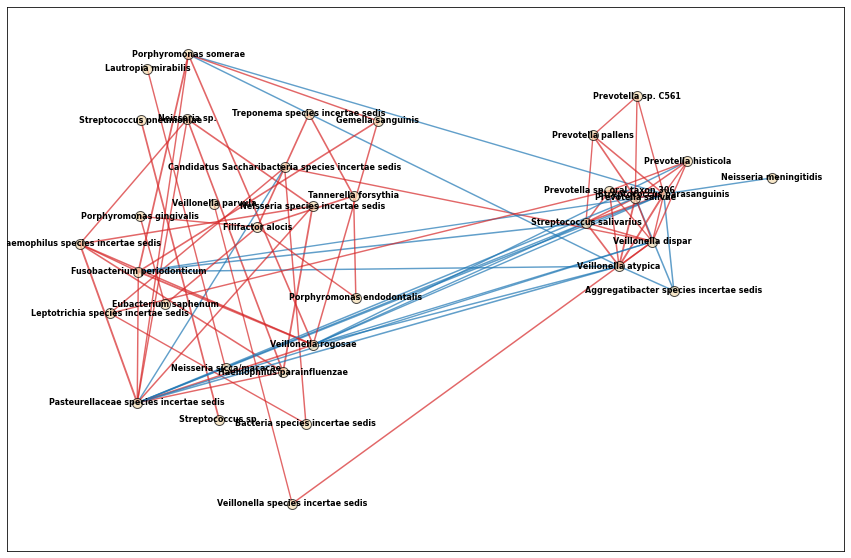

In [94]:
fig, ax = plt.subplots(1,1,figsize=(15,10))
nodecolors = [ 'wheat' for v in G_sp.nodes]
edgecolors = [G_sp[u][v]['edgecolor'] for u,v in G_sp.edges]
weights = [G_sp[u][v]['weight'] for u,v in G_sp.edges]
coms_sp = nx.community.greedy_modularity_communities(G_sp)
supergraph = nx.cycle_graph(len(coms_sp))
superpos = nx.spring_layout(G_sp, scale=3,seed=0)
centers = list(superpos.values())
pos = {}
for center, com in zip(centers, coms_sp):
    pos.update(nx.spring_layout(nx.subgraph(G_sp, com), center=center, seed=0))
for nodes in coms_sp:
    print(list(nodes))
    nx.draw_networkx_nodes(G_sp, pos=pos, nodelist=nodes, node_color='wheat',alpha=0.7,
                           edgecolors='black',node_size=100,ax=ax)
nx.draw_networkx_edges(G_sp, pos=pos,edge_color=edgecolors, width=weights, alpha=0.7,ax=ax)
nx.draw_networkx_labels(G_sp, pos=pos,font_weight='bold',font_size=8 );

# Species-metabolites